<a href="https://colab.research.google.com/github/MMVSILVA/Exercises_actions/blob/main/Exercicio_acoes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Obtenha dados de Petrobras (PETR4) desde o começo do ano de 2014 até ontem;

Crie uma lista de amostras de entrada contendo o número de dias que você achar adequado;

Divida os dados em dois grupos: amostras de treino, e amostras de teste (últimos 100 dias somente);

Execute o algoritmo SVM para treinar uma instância de previsão, utilizando somente as amostras de treino;

Faça o mesmo com o algoritmo xgboost;

Verifique o quanto seu algoritmo ficou competitivo, utilizando como critério o erro médio

Encontre a melhor configuração possível, ou seja, a configuração que apresente o menor erro que você conseguir.


In [ ]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import numpy as np
import datetime
import pandas_datareader.data as web
import yfinance as yf
yf.pdr_override()
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [ ]:
# Data inicial e final do histórico de preços
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime.now()

In [ ]:
# Le do servidor os dados da PETR4.SA (Petrobras Preferencial SA) entre as datas:
spy = web.get_data_yahoo('PETR4.SA',start,end) #Petrobráspetr4
spy

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,36.95,37.32,36.82,37.32,11.12,13303600
2010-01-05,37.38,37.43,36.80,37.00,11.02,21396400
2010-01-06,36.80,37.50,36.80,37.50,11.17,18720600
2010-01-07,37.27,37.45,37.07,37.15,11.07,10964600
2010-01-08,37.16,37.39,36.86,36.95,11.01,14624200
...,...,...,...,...,...,...
2023-08-18,31.41,31.68,31.18,31.52,30.36,45579700
2023-08-21,31.70,32.03,30.97,31.30,30.15,42236900
2023-08-22,30.50,30.61,30.24,30.61,30.61,31372200


In [ ]:
# Pega somente os preços de fechamento ('Close')
spy_c = spy['Close']
spy_c

Date
2010-01-04   37.32
2010-01-05   37.00
2010-01-06   37.50
2010-01-07   37.15
2010-01-08   36.95
              ... 
2023-08-18   31.52
2023-08-21   31.30
2023-08-22   30.61
2023-08-23   32.24
2023-08-24   32.19
Name: Close, Length: 3388, dtype: float64

Text(0.5, 1.0, 'PETR4.SA')

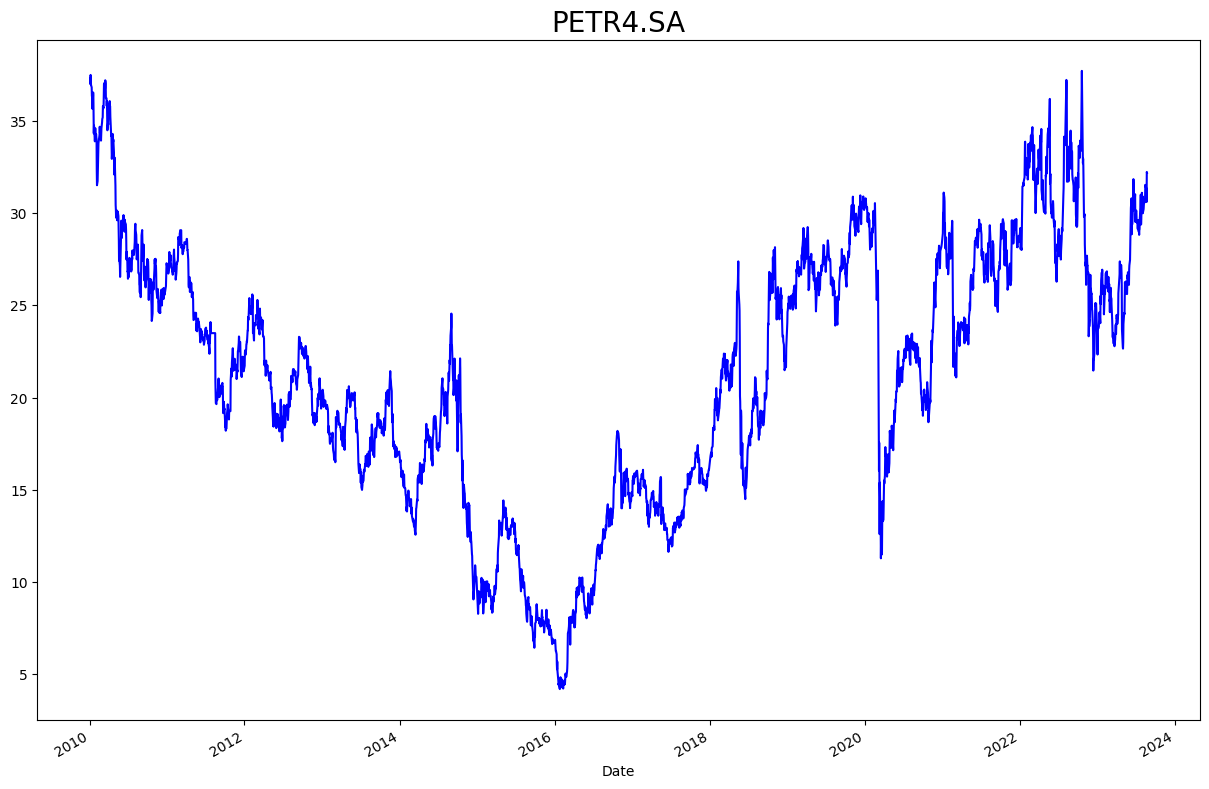

In [ ]:
# Cria um gráfico para vermos os preços:
fig, ax = plt.subplots(figsize=(15,10))
# A serie de valores de preço de fechamento será plotada na cor azul, blue, color='b':
spy_c.plot(color='b')
# Plota o grafico com nome de "PETR4" e 20 como tamanho da fonte:
plt.title("PETR4.SA", fontsize=20)

In [ ]:
# Pega o preço de abertura do primeiro dia:
first_open = spy['Open'].iloc[0]
first_open

36.95000076293945

In [ ]:
# Pega o preço de fechamento do último dia:
last_close = spy['Close'].iloc[-1]
last_close

32.189998626708984

In [ ]:
# Verifica a diferença entre os preços (valorização ou desvalorização?)
last_close - first_open

-4.760002136230469

In [ ]:
# Cria um novo vetor de preços contendo em cada dia as diferenças entre
# os preços de fechamento e abertura:
spy['Daily Change'] = pd.Series(spy['Close'] - spy['Open'])

In [ ]:
spy['Daily Change']

Date
2010-01-04    0.37
2010-01-05   -0.38
2010-01-06    0.70
2010-01-07   -0.12
2010-01-08   -0.21
              ... 
2023-08-18    0.11
2023-08-21   -0.40
2023-08-22    0.11
2023-08-23    1.04
2023-08-24   -0.08
Name: Daily Change, Length: 3388, dtype: float64

In [ ]:
# Os preços caíram, fato! Mas eles caíram mais durante a noite, ou durante os dias?
spy['Daily Change'].sum()

-72.46500539779663

In [ ]:
spy

,Open,High,Low,Close,Adj Close,Volume,Daily Change
Date,,,,,,,
2010-01-04,36.95,37.32,36.82,37.32,11.12,13303600,0.37
2010-01-05,37.38,37.43,36.80,37.00,11.02,21396400,-0.38
2010-01-06,36.80,37.50,36.80,37.50,11.17,18720600,0.70
2010-01-07,37.27,37.45,37.07,37.15,11.07,10964600,-0.12
2010-01-08,37.16,37.39,36.86,36.95,11.01,14624200,-0.21
...,...,...,...,...,...,...,...
2023-08-18,31.41,31.68,31.18,31.52,30.36,45579700,0.11
2023-08-21,31.70,32.03,30.97,31.30,30.15,42236900,-0.40
2023-08-22,30.50,30.61,30.24,30.61,30.61,31372200,0.11


In [ ]:
np.std(spy['Daily Change'])

0.44563165217178374

In [ ]:
# Cria um novo vetor de preços contendo em cada dia as diferenças entre
# os preços de abertura de hoje menos o valor de fechamento de ontem, ou seja,
# as variações noturnas dos preços. Vamos chamar isso de 'Overnight Change':
spy['Overnight Change'] = pd.Series(spy['Open'] - spy['Close'].shift(1))
np.std(spy['Overnight Change'])

0.3938187442374402

In [ ]:
spy['Overnight Change']

Date
2010-01-04     NaN
2010-01-05    0.06
2010-01-06   -0.20
2010-01-07   -0.23
2010-01-08    0.01
              ... 
2023-08-18   -0.03
2023-08-21    0.18
2023-08-22   -0.80
2023-08-23    0.59
2023-08-24    0.03
Name: Overnight Change, Length: 3388, dtype: float64

In [ ]:
spy['Overnight Change'].sum()

#spy[spy['Daily Change']>0]['Daily Change'].mean()

67.70500326156616

In [ ]:
spy[spy['Overnight Change']>0]['Overnight Change'].mean()

0.21427405690809773

In [ ]:
daily_rtn = ((spy['Close'] -spy['Close'].shift(1))/spy['Close'].shift(1))*100
id_rtn = ((spy['Close'] - spy['Open'])/spy['Open'])*100
on_rtn = ((spy['Open'] - spy['Close'].shift(1))/spy['Close'].shift(1))*100

In [ ]:
daily_rtn

Date
2010-01-04     NaN
2010-01-05   -0.86
2010-01-06    1.35
2010-01-07   -0.93
2010-01-08   -0.54
              ... 
2023-08-18    0.25
2023-08-21   -0.70
2023-08-22   -2.20
2023-08-23    5.33
2023-08-24   -0.16
Name: Close, Length: 3388, dtype: float64

In [ ]:
id_rtn

Date
2010-01-04    1.00
2010-01-05   -1.02
2010-01-06    1.90
2010-01-07   -0.32
2010-01-08   -0.57
              ... 
2023-08-18    0.35
2023-08-21   -1.26
2023-08-22    0.36
2023-08-23    3.33
2023-08-24   -0.25
Length: 3388, dtype: float64

In [ ]:
on_rtn

Date
2010-01-04     NaN
2010-01-05    0.16
2010-01-06   -0.54
2010-01-07   -0.61
2010-01-08    0.03
              ... 
2023-08-18   -0.10
2023-08-21    0.57
2023-08-22   -2.56
2023-08-23    1.93
2023-08-24    0.09
Length: 3388, dtype: float64

In [ ]:
# Função que recebe um série temporal e encontra estatíticas interessantes sobre essa série:
def get_stats(s, n=252):
    # Remove os valores ausentes do vetor, caso existam:
    s = s.dropna()
    # wins conterá o número de valores maiores que zero no vetor:
    wins = len(s[s>0])
    # losses conterá o número de valores menores que zero:
    losses = len(s[s<0])
    # Numero de valores iguais a zero (dias em que o preço não mudou):
    evens = len(s[s==0])
    # Media dos dias em que houve ganho:
    mean_w = round(s[s>0].mean(), 3)
    # Media dos dias em que houve perda:
    mean_l = round(s[s<0].mean(), 3)
    # Taxa de retorno: wins/loses:
    win_r = round(wins/losses, 3)
    # Media da serie:
    mean_trd = round(s.mean(), 3)
    # Desvio padrão da série:
    sd = round(np.std(s), 3)
    max_l = round(s.min(), 3)
    max_w = round(s.max(), 3)
    sharpe_r = round((s.mean()/np.std(s))*np.sqrt(n), 4)
    cnt = len(s)
    print('Trades:', cnt,\
        '\nWins:', wins,\
        '\nLosses:', losses,\
        '\nBreakeven:', evens,\
        '\nWin/Loss Ratio', win_r,\
        '\nMean Win:', mean_w,\
        '\nMean Loss:', mean_l,\
        '\nMean', mean_trd,\
        '\nStd Dev:', sd,\
        '\nMax Loss:', max_l,\
        '\nMax Win:', max_w,\
        '\nSharpe Ratio:', sharpe_r)

In [ ]:
get_stats(daily_rtn)

Trades: 3387 
Wins: 1690 
Losses: 1604 
Breakeven: 93 
Win/Loss Ratio 1.054 
Mean Win: 2.047 
Mean Loss: -2.075 
Mean 0.038 
Std Dev: 2.907 
Max Loss: -29.698 
Max Win: 22.222 
Sharpe Ratio: 0.2099


In [ ]:
get_stats(id_rtn)

Trades: 3388 
Wins: 1562 
Losses: 1713 
Breakeven: 113 
Win/Loss Ratio 0.912 
Mean Win: 1.677 
Mean Loss: -1.716 
Mean -0.095 
Std Dev: 2.262 
Max Loss: -17.382 
Max Win: 11.159 
Sharpe Ratio: -0.6647


In [ ]:
get_stats(on_rtn)

Trades: 3387 
Wins: 1839 
Losses: 1390 
Breakeven: 158 
Win/Loss Ratio 1.323 
Mean Win: 1.121 
Mean Loss: -1.153 
Mean 0.135 
Std Dev: 1.915 
Max Loss: -21.989 
Max Win: 19.841 
Sharpe Ratio: 1.1208


In [ ]:
from datetime import datetime
today = datetime.now().strftime('%Y-%m-%d')

start_date = pd.to_datetime('2014-01-01')
stop_date = pd.to_datetime(today)
sp = pdr.data.get_data_yahoo('PETR4.SA', start_date, stop_date)
sp

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,17.15,17.20,16.65,16.75,5.57,17284800
2014-01-03,16.74,16.78,16.41,16.50,5.49,17837600
2014-01-06,16.45,16.64,16.16,16.62,5.53,20526500
2014-01-07,16.65,16.83,16.12,16.16,5.37,19052500
2014-01-08,16.27,16.39,16.14,16.19,5.38,15874600
...,...,...,...,...,...,...
2023-08-18,31.41,31.68,31.18,31.52,30.36,45579700
2023-08-21,31.70,32.03,30.97,31.30,30.15,42236900
2023-08-22,30.50,30.61,30.24,30.61,30.61,31372200


Text(0.5, 1.0, 'PETR4')

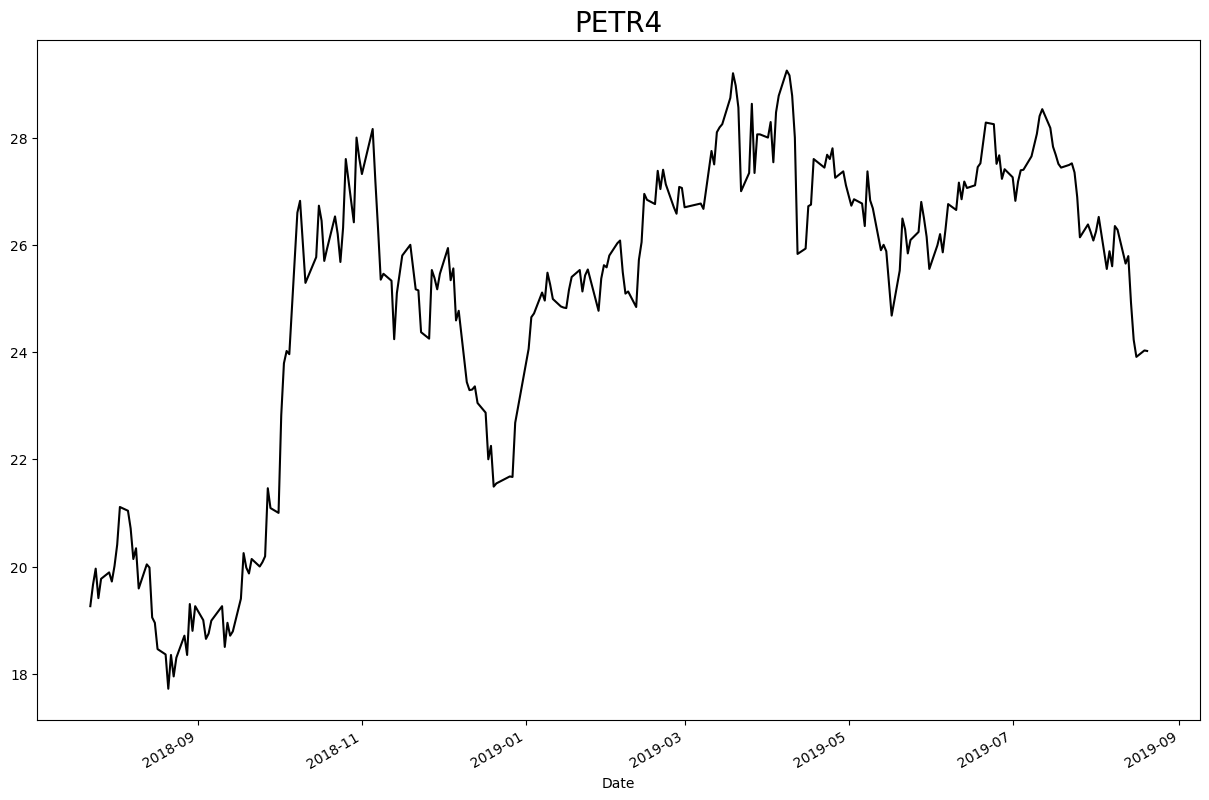

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
sp['Close'].plot(color='k')
plt.title("PETR4", fontsize=20)

In [ ]:
for i in range(1, 6, 1):
    sp.loc[:,'Close Minus ' + str(i)] = sp['Close'].shift(i)
    sp20 = sp[[x for x in sp.columns if 'Close Minus' in x or x =='Close']].iloc[5:,]
sp20

,Close,Close Minus 1,Close Minus 2,Close Minus 3,Close Minus 4,Close Minus 5
Date,,,,,,
2018-07-30,19.89,19.77,19.41,19.96,19.66,19.26
2018-07-31,19.72,19.89,19.77,19.41,19.96,19.66
2018-08-01,20.01,19.72,19.89,19.77,19.41,19.96
2018-08-02,20.41,20.01,19.72,19.89,19.77,19.41
2018-08-03,21.11,20.41,20.01,19.72,19.89,19.77
...,...,...,...,...,...,...
2019-08-14,24.92,25.79,25.65,26.28,26.35,25.60
2019-08-15,24.23,24.92,25.79,25.65,26.28,26.35
2019-08-16,23.91,24.23,24.92,25.79,25.65,26.28


In [ ]:
sp20 = sp20.iloc[:,::-1]
sp20

,Close Minus 5,Close Minus 4,Close Minus 3,Close Minus 2,Close Minus 1,Close
Date,,,,,,
2018-07-30,19.26,19.66,19.96,19.41,19.77,19.89
2018-07-31,19.66,19.96,19.41,19.77,19.89,19.72
2018-08-01,19.96,19.41,19.77,19.89,19.72,20.01
2018-08-02,19.41,19.77,19.89,19.72,20.01,20.41
2018-08-03,19.77,19.89,19.72,20.01,20.41,21.11
...,...,...,...,...,...,...
2019-08-14,25.60,26.35,26.28,25.65,25.79,24.92
2019-08-15,26.35,26.28,25.65,25.79,24.92,24.23
2019-08-16,26.28,25.65,25.79,24.92,24.23,23.91


In [ ]:
# Calcula o retorno (lucro) do movimento dos preços ao longo do dia, entre os fechamentos:
long_day_rtn = ((sp['Close'] - sp['Close'].shift(1))/sp['Close'].shift(1))*100
# Retorno intraday, ou seja entre a abertura e o fechamento:
long_id_rtn = ((sp['Close'] - sp['Open'])/sp['Open'])*100
# Retorno ao longo da noite, ou seja, entre o fechamento do dia anterior e a abertura:
long_on_rtn = ((sp['Open'] - sp['Close'].shift(1))/sp['Close'].shift(1))*100

In [ ]:
# Importa o SVM (Support Vector Machine) do sklearn
from sklearn.svm import SVR
clf = SVR(kernel='linear', verbose=1)
# Pega os últimos dias para criar amostras de treinamento:
X_train = sp20[:-100]
# E as correspondentes amostras de saída:
y_train = sp20['Close'].shift(-1)[:-100]
# Pega os últimos dias de amostras para teste:
X_test = sp20[-100:]
# E as correspondentes amostras de saída:
y_test = sp20['Close'].shift(-1)[-100:]

In [ ]:
# Treina o modelo usando somentes as amostras de treino:
model = clf.fit(X_train, y_train)

# Usa o modelo dando como entrada as amostras de teste, e obtém as saídas correspondentes da rede:
preds = model.predict(X_test)

[LibSVM]

In [ ]:
# Cria uma tabela comparativa de saída:
tf = pd.DataFrame(list(zip(y_test, preds)), columns=['Next Day Close','Predicted Next Close'], index=y_test.index)
tf

,Next Day Close,Predicted Next Close
Date,,
2019-03-28,28.06,28.19
2019-03-29,28.00,27.96
2019-04-01,28.29,27.93
2019-04-02,27.54,28.30
2019-04-03,28.47,27.58
...,...,...
2019-08-14,24.23,24.97
2019-08-15,23.91,24.38
2019-08-16,24.03,23.98


In [ ]:
# Importa a pandas com nome de referência pd:
import pandas as pd
from pandas_datareader import data, wb
# Importa o pyplot da matplotlib com nome de referência plt:
import matplotlib.pyplot as plt
# Importa a numpy com nome de referência np:
import numpy as np


# Leitor de dados financeiros do Pandas:
import pandas_datareader as pdr


# Obtendo dados de entrada:
start_date = pd.to_datetime('2018-07-21')
stop_date = pd.to_datetime('2019-08-21')
sp = pdr.data.get_data_yahoo('PETR4.SA', start_date, stop_date)

# Caso você queira visualizar os dados, decomente a linha abaixo:
sp



[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-07-23,19.30,19.47,19.21,19.26,6.84,35231500
2018-07-24,19.57,19.87,19.53,19.66,6.98,39934600
2018-07-25,19.80,20.00,19.61,19.96,7.09,48759900
2018-07-26,19.95,19.95,19.37,19.41,6.90,48144300
2018-07-27,19.60,19.81,19.55,19.77,7.02,36509400
...,...,...,...,...,...,...
2019-08-14,25.26,25.38,24.78,24.92,9.33,54401100
2019-08-15,24.99,25.00,24.14,24.23,9.07,53894500
2019-08-16,24.72,24.77,23.89,23.91,8.95,56782000


Text(0.5, 1.0, 'PETR4')

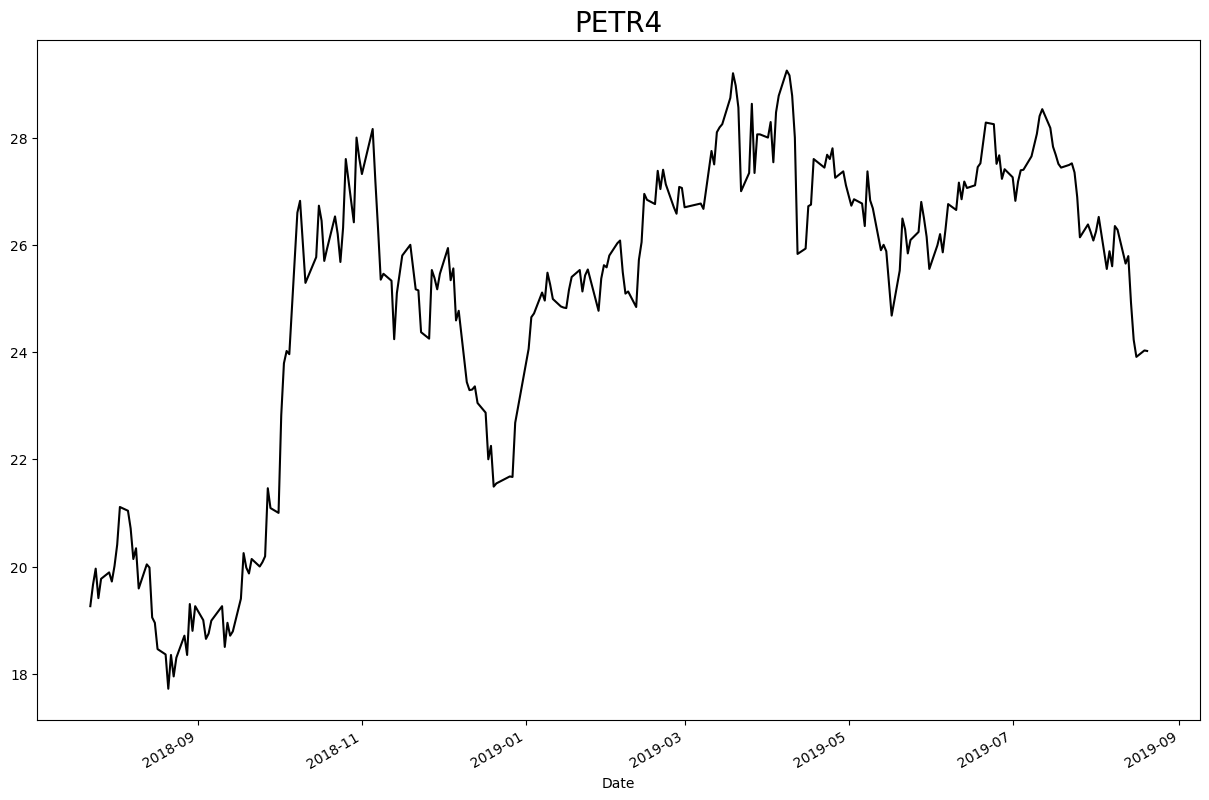

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
sp['Close'].plot(color='k')
plt.title("PETR4", fontsize=20)

In [ ]:
# Gera os as amostras de entrada com dias de entrada/saida:
for i in range(1, 6, 1):
    sp.loc[:,'Close Minus ' + str(i)] = sp['Close'].shift(i)
    sp20 = sp[[x for x in sp.columns if 'Close Minus' in x or x =='Close']].iloc[5:,]
sp20


,Close,Close Minus 1,Close Minus 2,Close Minus 3,Close Minus 4,Close Minus 5
Date,,,,,,
2018-07-30,19.89,19.77,19.41,19.96,19.66,19.26
2018-07-31,19.72,19.89,19.77,19.41,19.96,19.66
2018-08-01,20.01,19.72,19.89,19.77,19.41,19.96
2018-08-02,20.41,20.01,19.72,19.89,19.77,19.41
2018-08-03,21.11,20.41,20.01,19.72,19.89,19.77
...,...,...,...,...,...,...
2019-08-14,24.92,25.79,25.65,26.28,26.35,25.60
2019-08-15,24.23,24.92,25.79,25.65,26.28,26.35
2019-08-16,23.91,24.23,24.92,25.79,25.65,26.28


In [ ]:
sp20 = sp20.iloc[:,::-1]
sp20

,Close Minus 5,Close Minus 4,Close Minus 3,Close Minus 2,Close Minus 1,Close
Date,,,,,,
2018-07-30,19.26,19.66,19.96,19.41,19.77,19.89
2018-07-31,19.66,19.96,19.41,19.77,19.89,19.72
2018-08-01,19.96,19.41,19.77,19.89,19.72,20.01
2018-08-02,19.41,19.77,19.89,19.72,20.01,20.41
2018-08-03,19.77,19.89,19.72,20.01,20.41,21.11
...,...,...,...,...,...,...
2019-08-14,25.60,26.35,26.28,25.65,25.79,24.92
2019-08-15,26.35,26.28,25.65,25.79,24.92,24.23
2019-08-16,26.28,25.65,25.79,24.92,24.23,23.91


In [ ]:
# Calcula o retorno (lucro) do movimento dos preços ao longo do dia, entre os fechamentos:
long_day_rtn = ((sp['Close'] - sp['Close'].shift(1))/sp['Close'].shift(1))*100
# Retorno intraday, ou seja entre a abertura e o fechamento:
long_id_rtn = ((sp['Close'] - sp['Open'])/sp['Open'])*100
# Retorno ao longo da noite, ou seja, entre o fechamento do dia anterior e a abertura:
long_on_rtn = ((sp['Open'] - sp['Close'].shift(1))/sp['Close'].shift(1))*100

In [ ]:
# Importa o SVM (Support Vector Machine) do sklearn
from sklearn.svm import SVR
clf = SVR(kernel='linear', verbose=1)
# Pega os últimos dias para criar amostras de treinamento:
X_train = sp20[:-100]
# E as correspondentes amostras de saída:
y_train = sp20['Close'].shift(-1)[:-100]
# Pega os últimos dias de amostras para teste:
X_test = sp20[-100:]
# E as correspondentes amostras de saída:
y_test = sp20['Close'].shift(-1)[-100:]

In [ ]:
# O python tem maneiras mais espertas de separar (split) os datasets em conjuntos de treino e teste:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#X_total = PETR4_Data
#y_total = PETR4_Data['Close'].shift(-1)

#seed = 7
#test_size = 0.33
#X_train, X_test, y_train, y_test = train_test_split( X_total, y_total, test_size=test_size, random_state=seed)

In [ ]:
# Depois, podemos utilizar árvore de decisão (algoritmo xgboost) ao invés de SVM:
from xgboost import XGBClassifier


# fit model no training data
model_xgboost = XGBClassifier()
model_xgboost.fit(X_train, y_train)



In [ ]:
# Usa o modelo dando como entrada as amostras de teste, e obtém as saídas correspondentes da rede:
preds_xgboost = model_xgboost.predict(X_test)

# Cria uma tabela comparativa de saída:
tf = pd.DataFrame(list(zip(y_test, preds_xgboost)), columns=['Next Day Close','Predicted Next Close'], index=y_test.index)
tf

In [ ]:
from numpy import linalg as LA

# evaluate predictions
result = preds_xgboost - y_test

# Remove os valores ausentes do vetor, caso existam:
result = result.dropna()


LA.norm(result)/result.size

#accuracy = accuracy_score(y_test, preds)
#print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
# Importa o SVM (Support Vector Machine) do sklearn (aula passada):
from sklearn.svm import SVR
clf = SVR(kernel='linear', verbose=1)

# Treina o modelo usando somentes as amostras de treino:
model_SVM = clf.fit(X_train, y_train)


[LibSVM]

In [ ]:
# Usa o modelo dando como entrada as amostras de teste, e obtém as saídas correspondentes da rede:
preds_SVM = model_SVM.predict(X_test)

# Cria uma tabela comparativa de saída:
tf = pd.DataFrame(list(zip(y_test, preds_SVM)), columns=['Next Day Close','Predicted Next Close'], index=y_test.index)
tf

In [ ]:
# evaluate predictions
result = preds_SVM - y_test

# Remove os valores ausentes do vetor, caso existam:
result = result.dropna()


LA.norm(result)/result.size